['QQQ', '2023-10-25', '2023-11-25', '2m']: 2828


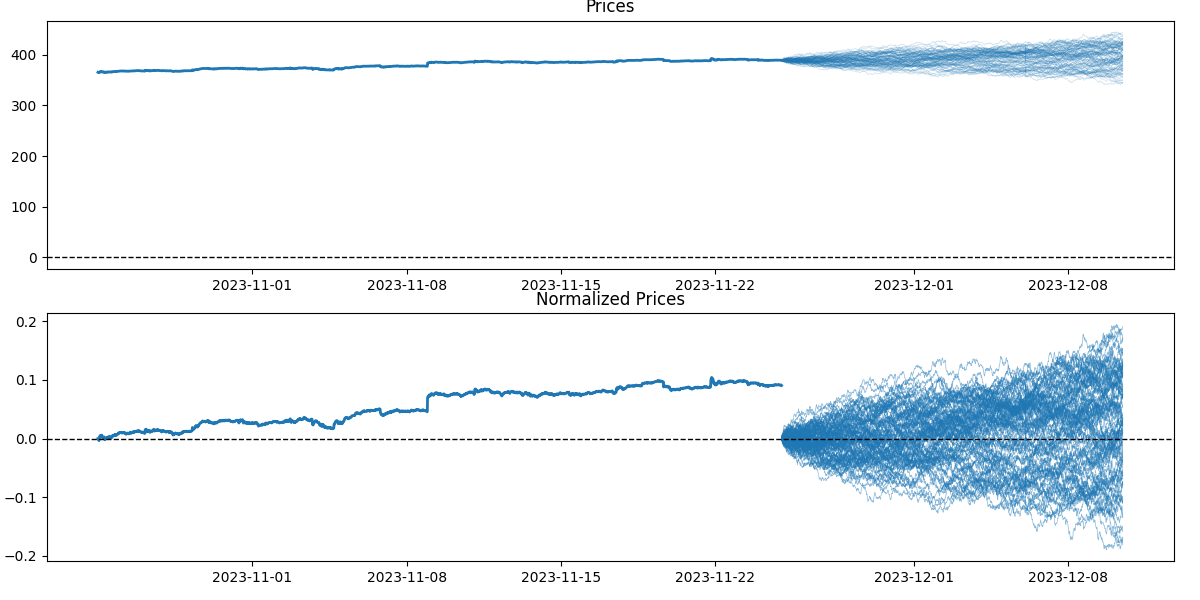

In [4]:
plt.close('all')
fig, axs = plt.subplots(2,1,figsize=(12, 6))
plt.tight_layout()

axs[0].set_title("Prices")
axs[1].set_title("Normalized Prices")

tickers = [
    # ['QQQ', '2021-03-01', '2021-09-01', '1d'],
    # ['QQQ', '2021-09-01', '2022-03-01', '1d'],
    # ['QQQ', '2022-03-01', '2022-09-01', '1d'],
    # ['QQQ', '2022-09-01', '2023-03-01', '1d'],
    # ['QQQ', '2023-03-01', '2023-09-01', '1d'],

    ['QQQ', '2023-10-25', '2023-11-25', '2m'],


    # ['YINN', '2021-03-01', '2021-09-01', '1d'],
    # ['YINN', '2021-09-01', '2022-03-01', '1d'],
    # ['YINN', '2022-03-01', '2022-09-01', '1d'],
    # ['YINN', '2022-09-01', '2023-03-01', '1d'],
    # ['YINN', '2023-03-01', '2023-09-01', '1d'],

    # ['VOO', '2023-01-01', '2023-12-01', '1h'],
    # ['YINN', '2015-01-01', '2015-12-01', '1d'],
    # ['O', '2016-01-01', '2016-12-01', '1d'],
    # ['O', '2023-09-01', '2023-12-01', '1h'],
]
for ticker in tickers:
    prices_raw = np.array(yf.Ticker(ticker[0]).history(start=ticker[1], end=ticker[2], interval=ticker[3])['Close'])
    prices_raw = prices_raw[~np.isnan(prices_raw)]

    print(f"{ticker}: {len(prices_raw)}")
    ticker_str = ticker[0]

    start_date = datetime.strptime(ticker[1], '%Y-%m-%d')
    end_date = datetime.strptime(ticker[2], '%Y-%m-%d')
    date_array = np.linspace(start_date.timestamp(), end_date.timestamp(), len(prices_raw))
    date_objects = [datetime.fromtimestamp(ts) for ts in date_array]
    date_objects_next = [datetime.fromtimestamp(ts)+(end_date-start_date) for ts in date_array]
    axs[0].plot(date_objects, prices_raw, label=ticker_str, linewidth=2)

    # prices = np.log2(prices_raw / prices_raw.mean())
    prices = np.log2(prices_raw / prices_raw[0])
    axs[1].plot(date_objects, prices, label=ticker_str, linewidth=2)

    nyquist_freq = (len(prices) // 2) + 1
    spectrum = np.fft.fft(prices)[:nyquist_freq]
    amplitudes = np.abs(spectrum)
    phases = np.angle(spectrum)


    for i in range(100):
        phases_sim = np.random.uniform(0, 2*pi, size=nyquist_freq)
        spectrum_sim = amplitudes * np.exp(1j * (phases_sim))
        prices_sim = np.fft.ifft(spectrum_sim).real

        # spectrum_sim[50:] = 0    #low pass filter
        if(len(prices)%2==0):
            spectrum_sim = np.concatenate((spectrum_sim[:-1], np.conj(spectrum_sim[-1:0:-1]))) #second half is the negative frequencies, reverse and remove last element, then take last element
        else:
            spectrum_sim = np.concatenate((spectrum_sim, np.conj(spectrum_sim[-1:0:-1])))
        prices_sim = np.fft.ifft(spectrum_sim).real

        # only the first half of the IFFT is reasonable
        halflen = len(prices_sim)//2
        date_objects_next = date_objects_next[:halflen]
        prices_sim = prices_sim[:halflen]

        prices_sim = (prices_sim - prices_sim[0])

        x = np.linspace(1e-6, pi/2, len(prices_sim))
        prices_sim = np.multiply(prices_sim, x/np.sin(x))

        color = axs[1].lines[-1].get_color()
        axs[1].plot(date_objects_next, prices_sim, label=i, linewidth=0.5, color=color, alpha=0.5)


        prices_predict = prices_raw[-1]*np.exp2(prices_sim)
        # prices_predict = prices_raw[-1]*np.power(3, prices_sim)
        axs[0].plot(date_objects_next, prices_predict, label=i, linewidth=0.5, color=color, alpha=0.2)
        
    axs[0].axhline(y=0, color='k', linestyle='--', linewidth=1)
    axs[1].axhline(y=0, color='k', linestyle='--', linewidth=1)
    # axs[0].legend()




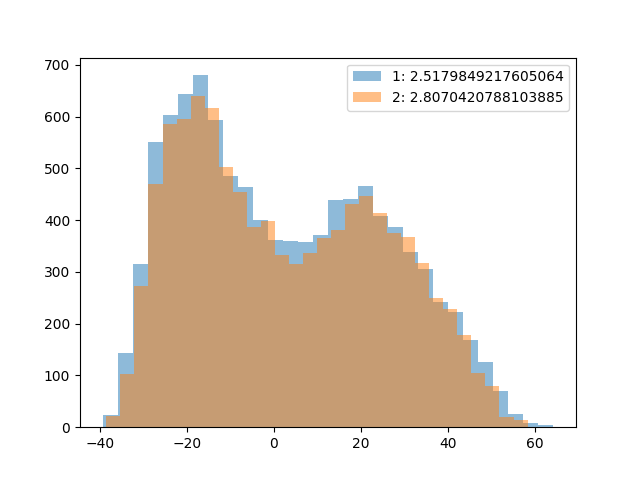

In [11]:


def run_grid_arr2(params, prices_arr):
    thresS, thresB, sell_max, buy_max = params
    (num_sims, price_len) = prices_arr.shape
    earned = np.zeros(num_sims)
    for sim_num in range(num_sims):
        P = prices_arr[sim_num]
        last_trans = P[0]
        shares = 0 #shares
        cash = 1
        for k in range(1,price_len):
            if(((P[k] - last_trans)/last_trans > thresS) and shares > 0):
                sell_amt = min(sell_max, shares*P[k])
                shares -= sell_amt/P[k]
                cash += sell_amt
                last_trans = P[k]
            if(((P[k] - last_trans)/last_trans < thresB or (shares <= 0 and (P[k]-P[k-1])/P[k-1] < thresB)) and cash > 0):
                buy_amt = min(buy_max, cash)
                shares += buy_amt/P[k]
                cash -= buy_amt
                last_trans = P[k]
        earned[sim_num] = 100*((cash + shares*P[-1]) - 1)
    return earned

params = [0.06530, -0.00156, 0.17535, 0.17855,]
earned1 = run_grid_arr1(params, all_sims[:10000])

params = [0.02539, -0.01037, 0.09779, 0.14371,]
earned2 = run_grid_arr2(params, all_sims[:10000])

plt.figure()
plt.hist(earned1, bins=30, label=f'1: {earned1.mean()}', alpha=0.5)
plt.hist(earned2, bins=30, label=f'2: {earned2.mean()}', alpha=0.5)
plt.legend()
plt.show()



In [1]:

import sim
import optimizer
import matplotlib.pyplot as plt

# %matplotlib widget

symbol = 'VOO'

base_ticker = [symbol, '2022-09-1', '2022-12-01', '1h']  # historical data: [ticker, start_date, end_date, interval]
prices_raw = sim.gen_sim_file(base_ticker)
all_sims = sim.read_sim_file()

plt.figure()
plt.title(f"One Sim & Base ({'_'.join(base_ticker)})")
plt.plot(prices_raw, label='base')
plt.plot(all_sims[:1].T, label='sim')
plt.legend()
plt.show()

params = optimizer.find_params(all_sims)
# params = [0.04464, -0.01936, 0.17922, 0.33714,]  # sell_thres, buy_thres, sell_percent, buy_percent
print("---- found optimal params: " + str(params))

test_ticker = [symbol, '2023-09-1', '2023-12-01', '1h']  # test data

optimizer.test_params(params, test_ticker)

['VOO', '2022-09-1', '2022-12-01', '1h']
